In [62]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
import pandas as pd
from matplotlib import pyplot
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pycountry_convert as pc
import folium 
from datetime import datetime
from datetime import timedelta

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
import matplotlib.dates as mdate
pio.templates.default = "plotly_dark"

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

torch.manual_seed(0)
np.random.seed(0)
# torch.cuda.set_device(1)


In [63]:
def error_mse(ty, py):
    mse = mean_squared_error(ty, py)
    return mse

def error_rmsle(ty, py):
    rmsle = np.sqrt(mean_squared_log_error(ty, py))
    return rmsle

def error_mae(ty, py):
    mae = mean_absolute_error(ty, py)
    return mae

def error_mape(ty, py):
    mape = np.mean(np.abs((py - ty) / ty)) 
    return mape

def error_rmse(ty, py):
    mse = mean_squared_error(ty, py)    
    rmse = np.sqrt(mse)
    return rmse

In [64]:
# S is the source sequence length
# T is the target sequence length
# N is the batch size
# E is the feature number

#src = torch.rand((10, 32, 512)) # (S,N,E) 
#tgt = torch.rand((20, 32, 512)) # (T,N,E)
#out = transformer_model(src, tgt)

input_window = 50 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
batch_size = 100 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]
          
class TransAm(nn.Module):
    def __init__(self,feature_size=250,num_layers=1,dropout=0.05):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

def _log2(data):
    return np.exp(np.exp(data))
    
# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]
def create_inout_sequences(input_data, tw, ganData = None):
    inout_seq = []
    inout_seq.extend(create_inout_sequences_front(input_data, tw))
    inout_seq.extend(create_inout_sequences_back(input_data, tw))
    if ganData is not None:
        inout_seq.extend(create_train_sequences(ganData, tw))
    return torch.FloatTensor(inout_seq)

def create_train_sequences(input_data, tw):
    inout_seq = []
    input_data = input_data.reshape(input_data.shape[0], input_data.shape[1])
    for i in range(input_data.shape[0]):
        train_seq = input_data[i][0:tw]
        train_label = input_data[i][1:tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq
    
def create_inout_sequences_front(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

def create_inout_sequences_back(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(tw, L, 1):
        train_seq = input_data[i - tw : i ]
        train_label = input_data[i - tw + output_window : i + output_window]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

def log2_(df):
    df = df[df["confirmed"] >= 3]
    df = df[df["fatalities"] >= 3]
    df["confirmed"] = np.log(np.log(df["confirmed"]))
    df["fatalities"] = np.log(np.log(df["fatalities"]))
    idex = list(range(0, df.shape[0]))
    df["day"] = idex
    return df

def addCsv(df): #累加
    temp_df = df.copy()
    #  ->   2021/4/29新加入代码
#     temp_df = temp_df[temp_df["confirmed"] >= 1]
#     temp_df = temp_df[temp_df["fatalities"] >= 1]
    #  <-  2021/4/29新加入代码
    confirmed_ = np.array(temp_df['confirmed'].astype(np.float32)).reshape(-1, 1)
    fatalities_ = np.array(temp_df['fatalities'].astype(np.float32)).reshape(-1, 1)
    for i in range(confirmed_.shape[0] - 1):
        confirmed_[i+1] += confirmed_[i]
    for i in range(fatalities_.shape[0] - 1):
        fatalities_[i+1] += fatalities_[i]    
    temp_df['confirmed'] = confirmed_
    temp_df['fatalities'] = fatalities_
    return temp_df

from sklearn.preprocessing import StandardScaler
class DealData:
    def __init__(self, truthName, ganName = None):
        self.scaler = StandardScaler()  #'/home/soul/NewWorkSpace/Informer2020CP/data/ETT/global.csv'
        self.amplitude = pd.read_csv(truthName)
        self.amplitude =  np.array(self.amplitude['fatalities'].astype(np.float32))
        
        self.scaler.fit(self.amplitude.reshape(-1, 1))
        self.amplitude = self.scaler.transform(self.amplitude.reshape(-1, 1)).reshape(-1)
        #         _del30_confirmed_SJ_noise_61_1000
        #/home/soul/NewWorkSpace/Covid_2021_4_18/ganData/stand_global_+_del30_confirmed_noise_61_1000.npy
        if ganName is not None:
            self.trainData = np.load(ganName)
        else:
            self.trainData = None
        
    def trainTestData(self):
        train_sampels = -30
        test_samples = -80
        train_data = self.amplitude[:train_sampels]
        test_data = self.amplitude[test_samples:]

        train_sequence = create_inout_sequences(train_data, input_window, self.trainData)
        test_sequenc = create_inout_sequences(test_data, input_window)
        
        return train_sequence.to(device),test_sequenc.to(device)
    
    def train_data(self):
        train_sequence = create_train_sequences(self.trainData, input_window, self.trainData)
        return train_sequence.to(device)
    
    def trainPredictData(self):
        self.trainData = np.load("/home/soul/NewWorkSpace/Covid_2021_4_18/ganData/stand_global_+_confirmed_noise_61_1000.npy")
        train_data = self.amplitude
        train_sequence = create_inout_sequences(train_data, input_window, self.trainData)
        return train_sequence.to(device)
    
    def get_plot_data(self, eval_model):
        eval_model.eval() 
        test_result = torch.Tensor(0)    
        truth = torch.Tensor(0)
        
        temp_data = torch.FloatTensor(self.amplitude[0:input_window])
        test_result = torch.cat((test_result, temp_data), 0)
        truth = torch.cat((truth, temp_data), 0)
        
        data_source = torch.FloatTensor(create_inout_sequences_back(self.amplitude, input_window)).to(device)
        with torch.no_grad():
            for i in range(0, len(data_source)):
                data, target = get_batch(data_source, i,1)
                output = eval_model(data)    
                test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
                truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
            
            mse   = error_mse(truth[-30:], test_result[-30:])
#             rmsle = error_rmsle(truth[-30:], test_result[-30:])
            rmsle = 0.0
            mae   = error_mae(truth[-30:], test_result[-30:])
            mape  = error_mape(truth[-30:].numpy(), test_result[-30:].numpy())
            rmse  = error_rmse(truth[-30:], test_result[-30:])
                
        print(len(test_result), len(truth))
        truth = self.scaler.inverse_transform(truth)
        test_result = self.scaler.inverse_transform(test_result)
        return mse, rmsle, mae, mape, rmse, truth, test_result

    
    def plot_and_loss(self, eval_model,epoch, test = False):
        eval_model.eval() 
        total_loss = 0.
        test_result = torch.Tensor(0)    
        truth = torch.Tensor(0)
        
        temp_data = torch.FloatTensor(self.amplitude[0:input_window])
        test_result = torch.cat((test_result, temp_data), 0)
        truth = torch.cat((truth, temp_data), 0)
        
        data_source = torch.FloatTensor(create_inout_sequences_back(self.amplitude, input_window)).to(device)
        with torch.no_grad():
            for i in range(0, len(data_source)):
                data, target = get_batch(data_source, i,1)
                output = eval_model(data)    
                test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
                truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
                
            mse = error_mse(truth[-30:], test_result[-30:])
#             rmsle = error_rmsle(truth[-30:], test_result[-30:])
            rmsle = 0.0
        
            if test == False:
                temp_truth = truth
                for t in range(0, 30):
                    data = np.array(temp_truth[-input_window:]).reshape([input_window, 1, 1]).astype(np.float32)
                    output = eval_model(torch.FloatTensor(data).to(device))   
                    temp_truth = torch.cat((temp_truth, output[-1].view(-1).cpu()), 0)
                    test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
                
        print(len(test_result), len(truth))
        truth = self.scaler.inverse_transform(truth)
        test_result = self.scaler.inverse_transform(test_result)
        
        fig = pyplot.figure(figsize=[20, 10])
        pyplot.title('Global Confirmed Data')
        pyplot.plot(truth[-100:], color='blue', marker='o')
        pyplot.plot(truth[-100:],color="blue", label = 'Measured')
        
        if test == False:
            pyplot.plot(test_result[-130:], color='green', marker='o')
            pyplot.plot(test_result[-130:], color="green", label = 'Predicted')

            pyplot.plot(test_result[-130:-30], color='red', marker='o')
            pyplot.plot(test_result[-130:-30], color="red", label = 'Predicted')        
        else:
            pyplot.plot(test_result[-100:], color='green', marker='o')
            pyplot.plot(test_result[-100:], color="green", label = 'Predicted')

            pyplot.plot(test_result[-100:-30], color='red', marker='o')
            pyplot.plot(test_result[-100:-30], color="red", label = 'Predicted')
        pyplot.show()
        pyplot.close()
        
        
        pyplot.title('Global Confirmed Data')
        pyplot.plot(test_result,color="green", label = 'Predicted')
        pyplot.plot(test_result[:-30],color="red", label = 'Predicted')
        pyplot.plot(truth,color="blue", label = 'Measured')
        pyplot.grid(True)
        pyplot.legend(loc='best')
    #     pyplot.savefig('graph/transformer-epoch%d.png'%epoch)
        pyplot.show()
        pyplot.close()
        
        return mse, rmsle


def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - i) #len(source) - 1 - i
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
    return input, target


def train(train_data):
    model.train() # Turn on the train mode \o/
    total_loss = 0.
    start_time = time.time()
    a = output_window / input_window
    b = 1 - a
    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
#         loss = criterion(output[-output_window:], targets[-output_window:])
#         loss =  a * criterion(output[:-output_window], targets[:-output_window]) + b * criterion(output[-output_window:], targets[-output_window:])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 10
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)            
            total_loss += criterion(output[-output_window:], targets[-output_window:]).cpu().item()
    return total_loss / len(data_source)


def saveModel(model, name):
    # 保存
    torch.save(model.state_dict(), './saveModel/' + name + '.pkl')

def loadModel(model, name):
    # 加载
    model.load_state_dict(torch.load('./saveModel/' + name + '.pkl'))
    return model


def save_epoch_data(epochs = 20):
    df = pd.DataFrame()
    df['X'] = []
    df['Y'] = []
    
    frames = []
    for i in range(epochs):
        model = TransAm().to(device)
        model = loadModel(model, "parameter_global_confirmed_50sq_del30_changeLoss_noise_" + str(i) + "_best")
        dealData = DealData()
        truths, predicts = dealData.get_plot_data(model)
    
        temp_df = pd.DataFrame()
        temp_df['X'] = range(len(predicts))
        temp_df['Y'] = predicts
        
        frames.append(temp_df)
        
    result = pd.concat(frames)
    result.to_csv("epoch_data_changLoss_noise_20.csv")

    
def plog_epoch_image(epochs = 20):
    
    df = pd.read_csv("epoch_data_changLoss_noise_20.csv")

    sns.lineplot(x="X", y="Y",color="red", ci="sd", data=df)
    
#     plt.plot(serise, truth[-100:], color='purple', marker='o')
#     plt.plot(serise, truth[-100:],color="purple", label = 'Reported')

#     plt.plot(serise, predict[-100:], color='orange', marker='o')
#     plt.plot(serise, predict[-100:], color="orange", label = 'Projection')

#     plt.plot(serise, predict[-100:-30], color='crimson', marker='o')
#     plt.plot(serise, predict[-100:-30], color="crimson", label = 'Fitting')


def plot_image(truth, predict, start = '2020-01-22', end = '2021-04-25', title = 'Global Fatality Data', isSave = False):
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1,1,1)
    ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))#设置时间标签显示格式
    serise= pd.date_range(start, end)
    plt.xticks(pd.date_range(start, end, freq='30d'),rotation=45)
    plt.title(title)
    
    plt.plot(serise, truth,color="purple", label = 'Reported')
    plt.plot(serise, predict, color="orange", label = 'Projection')
    plt.plot(serise[:-30], predict[:-30], color="crimson", label = 'Fitting')
    plt.grid(True, which='both')
    
    if isSave == True:
        plt.savefig('./image/' + title)
    plt.show()


In [55]:
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv",
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_global_del30_fatality_SJ_noise_1000_everyday.npy")
train_data, val_data = dealData.trainTestData()
print(train_data.shape, val_data.shape) 

torch.Size([1760, 2, 50]) torch.Size([60, 2, 50])


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch   1 |     3/   17 batches | lr 0.005000 | 47.11 ms | loss 79.69958 | ppl 41028746625404525191817995082530816.00
| epoch   1 |     6/   17 batches | lr 0.005000 | 33.21 ms | loss 18.76575 | ppl 141209255.27
| epoch   1 |     9/   17 batches | lr 0.005000 | 31.35 ms | loss 2.35337 | ppl    10.52
| epoch   1 |    12/   17 batches | lr 0.005000 | 30.66 ms | loss 3.19853 | ppl    24.50
| epoch   1 |    15/   17 batches | lr 0.005000 | 29.29 ms | loss 0.84420 | ppl     2.33
| epoch   2 |     3/   17 batches | lr 0.004513 | 41.51 ms | loss 1.35506 | ppl     3.88
| epoch   2 |     6/   17 batches | lr 0.004513 | 31.15 ms | loss 0.50982 | ppl     1.66
| epoch   2 |     9/   17 batches | lr 0.004513 | 28.85 ms | loss 2.05885 | ppl     7.84
| epoch   2 |    12/   17 batches | lr 0.004513 | 29.20 ms | loss 0.96770 | ppl     2.63
| epoch   2 |    15/   17 batches | lr 0.004513 | 25.33 ms | loss 0.85715 | ppl     2.36
| epoch   3 |     3/   17 batches | lr 0.004287 | 56.50 ms | loss 3.19747 

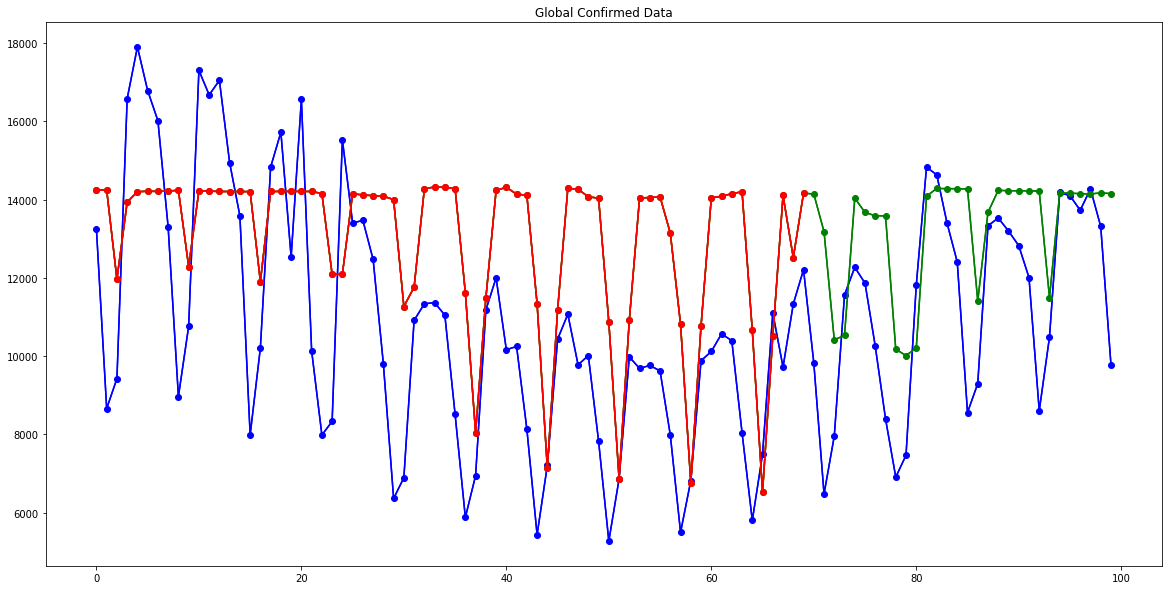

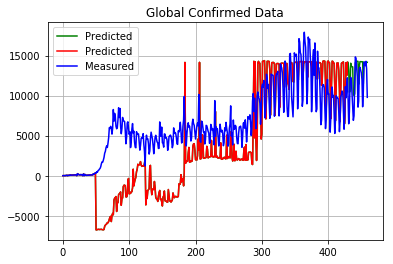

-----------------------------------------------------------------------------------------
| end of epoch  10 | time:  3.37s | mse loss 0.45712 | rmsle loss 0.00000 
-----------------------------------------------------------------------------------------
| epoch  11 |     3/   17 batches | lr 0.002844 | 34.36 ms | loss 1.44325 | ppl     4.23


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  11 |     6/   17 batches | lr 0.002844 | 53.69 ms | loss 0.22032 | ppl     1.25
| epoch  11 |     9/   17 batches | lr 0.002844 | 26.53 ms | loss 0.64245 | ppl     1.90
| epoch  11 |    12/   17 batches | lr 0.002844 | 53.61 ms | loss 0.58173 | ppl     1.79
| epoch  11 |    15/   17 batches | lr 0.002844 | 30.91 ms | loss 0.56574 | ppl     1.76
| epoch  12 |     3/   17 batches | lr 0.002702 | 34.17 ms | loss 1.80947 | ppl     6.11
| epoch  12 |     6/   17 batches | lr 0.002702 | 25.04 ms | loss 0.44652 | ppl     1.56
| epoch  12 |     9/   17 batches | lr 0.002702 | 26.47 ms | loss 1.16968 | ppl     3.22
| epoch  12 |    12/   17 batches | lr 0.002702 | 25.97 ms | loss 0.84950 | ppl     2.34
| epoch  12 |    15/   17 batches | lr 0.002702 | 24.74 ms | loss 0.56194 | ppl     1.75
| epoch  13 |     3/   17 batches | lr 0.002567 | 34.94 ms | loss 0.44178 | ppl     1.56
| epoch  13 |     6/   17 batches | lr 0.002567 | 24.63 ms | loss 0.18179 | ppl     1.20
| epoch  13 |     9/ 

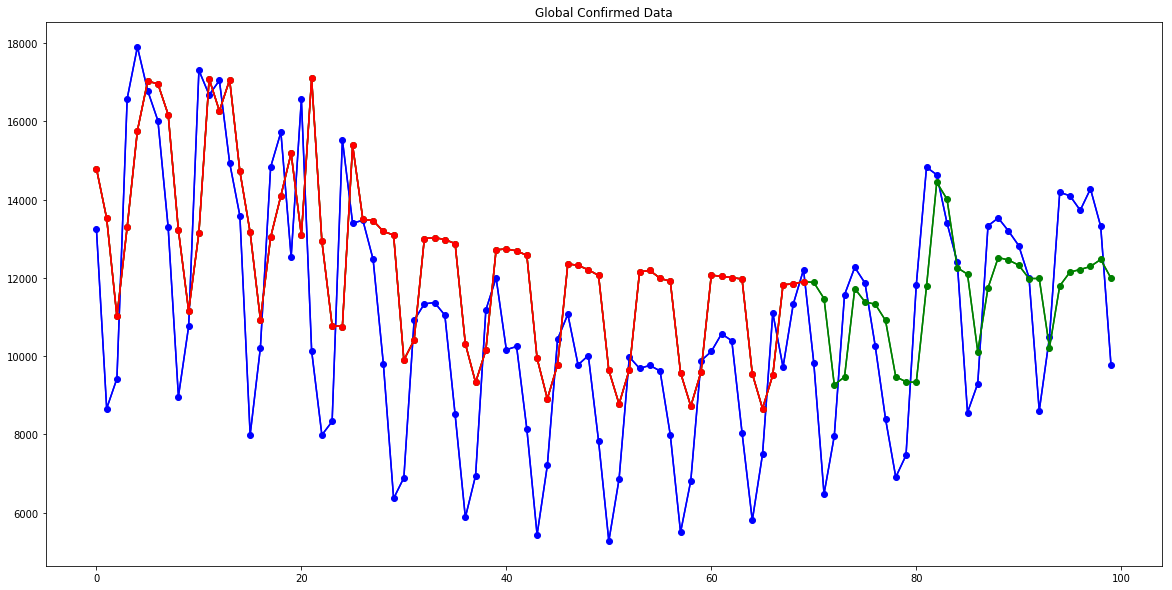

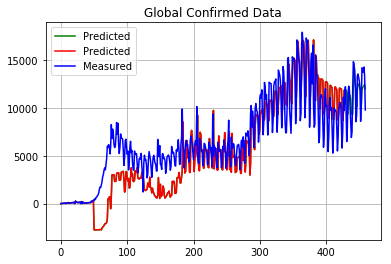

-----------------------------------------------------------------------------------------
| end of epoch  20 | time:  3.32s | mse loss 0.22979 | rmsle loss 0.00000 
-----------------------------------------------------------------------------------------
| epoch  21 |     3/   17 batches | lr 0.001703 | 32.37 ms | loss 0.51246 | ppl     1.67
| epoch  21 |     6/   17 batches | lr 0.001703 | 23.79 ms | loss 0.19324 | ppl     1.21


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  21 |     9/   17 batches | lr 0.001703 | 24.08 ms | loss 0.38700 | ppl     1.47
| epoch  21 |    12/   17 batches | lr 0.001703 | 24.24 ms | loss 0.39355 | ppl     1.48
| epoch  21 |    15/   17 batches | lr 0.001703 | 23.18 ms | loss 0.38959 | ppl     1.48
| epoch  22 |     3/   17 batches | lr 0.001618 | 32.80 ms | loss 0.67700 | ppl     1.97
| epoch  22 |     6/   17 batches | lr 0.001618 | 24.08 ms | loss 0.23544 | ppl     1.27
| epoch  22 |     9/   17 batches | lr 0.001618 | 24.13 ms | loss 0.59416 | ppl     1.81
| epoch  22 |    12/   17 batches | lr 0.001618 | 24.55 ms | loss 0.51664 | ppl     1.68
| epoch  22 |    15/   17 batches | lr 0.001618 | 23.73 ms | loss 0.42852 | ppl     1.53
| epoch  23 |     3/   17 batches | lr 0.001537 | 32.50 ms | loss 0.30967 | ppl     1.36
| epoch  23 |     6/   17 batches | lr 0.001537 | 23.75 ms | loss 0.17182 | ppl     1.19
| epoch  23 |     9/   17 batches | lr 0.001537 | 24.17 ms | loss 0.41518 | ppl     1.51
| epoch  23 |    12/ 

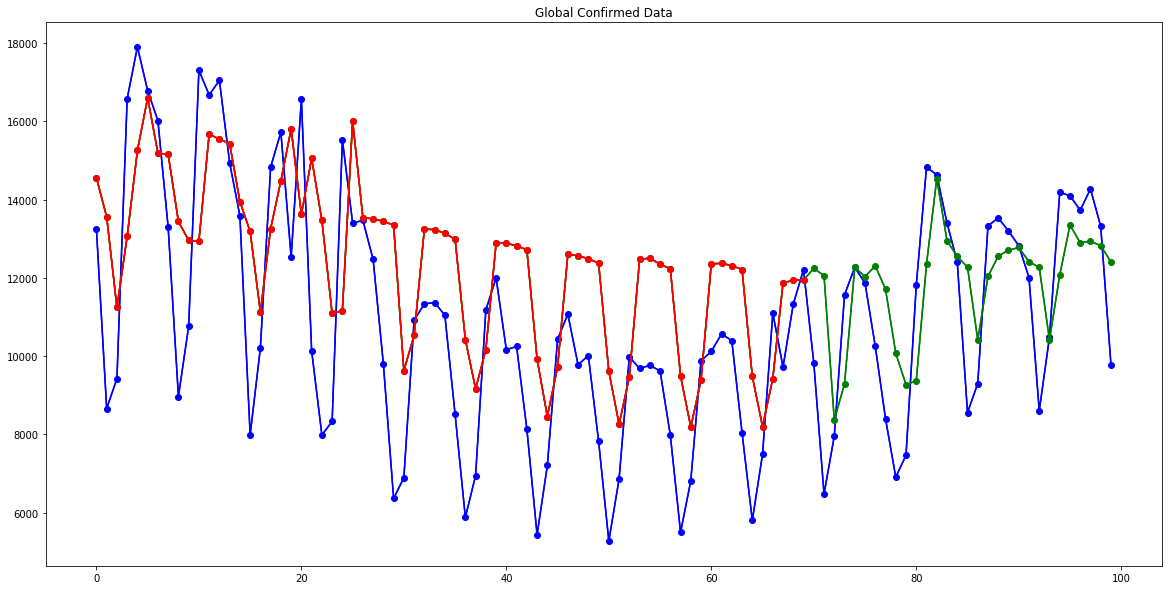

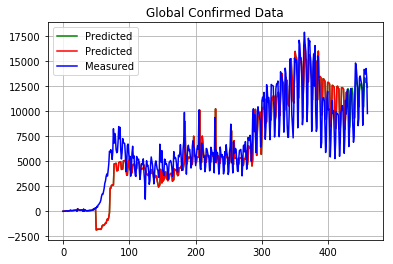

-----------------------------------------------------------------------------------------
| end of epoch  30 | time:  3.53s | mse loss 0.24829 | rmsle loss 0.00000 
-----------------------------------------------------------------------------------------
| epoch  31 |     3/   17 batches | lr 0.001020 | 34.70 ms | loss 0.31851 | ppl     1.38
| epoch  31 |     6/   17 batches | lr 0.001020 | 25.68 ms | loss 0.15316 | ppl     1.17


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  31 |     9/   17 batches | lr 0.001020 | 24.81 ms | loss 0.35890 | ppl     1.43
| epoch  31 |    12/   17 batches | lr 0.001020 | 24.29 ms | loss 0.36363 | ppl     1.44
| epoch  31 |    15/   17 batches | lr 0.001020 | 23.29 ms | loss 0.35762 | ppl     1.43
| epoch  32 |     3/   17 batches | lr 0.000969 | 32.80 ms | loss 0.31568 | ppl     1.37
| epoch  32 |     6/   17 batches | lr 0.000969 | 24.04 ms | loss 0.14441 | ppl     1.16
| epoch  32 |     9/   17 batches | lr 0.000969 | 24.81 ms | loss 0.38363 | ppl     1.47
| epoch  32 |    12/   17 batches | lr 0.000969 | 24.28 ms | loss 0.36811 | ppl     1.45
| epoch  32 |    15/   17 batches | lr 0.000969 | 23.80 ms | loss 0.35961 | ppl     1.43
| epoch  33 |     3/   17 batches | lr 0.000920 | 34.23 ms | loss 0.26942 | ppl     1.31
| epoch  33 |     6/   17 batches | lr 0.000920 | 24.46 ms | loss 0.13889 | ppl     1.15
| epoch  33 |     9/   17 batches | lr 0.000920 | 26.78 ms | loss 0.35630 | ppl     1.43
| epoch  33 |    12/ 

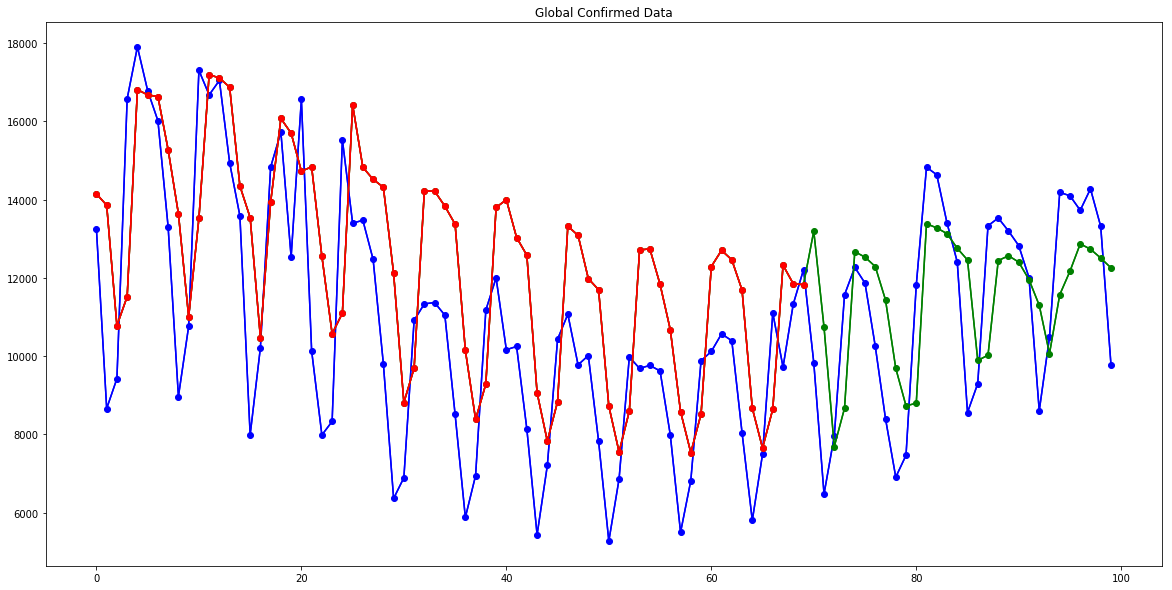

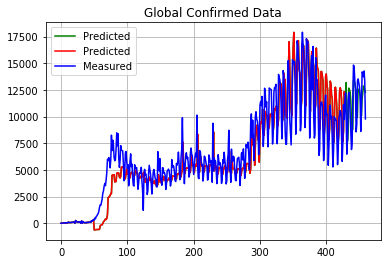

-----------------------------------------------------------------------------------------
| end of epoch  40 | time:  3.43s | mse loss 0.25080 | rmsle loss 0.00000 
-----------------------------------------------------------------------------------------
| epoch  41 |     3/   17 batches | lr 0.000610 | 32.12 ms | loss 0.23370 | ppl     1.26
| epoch  41 |     6/   17 batches | lr 0.000610 | 23.79 ms | loss 0.13906 | ppl     1.15


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  41 |     9/   17 batches | lr 0.000610 | 23.85 ms | loss 0.34465 | ppl     1.41
| epoch  41 |    12/   17 batches | lr 0.000610 | 24.98 ms | loss 0.33433 | ppl     1.40
| epoch  41 |    15/   17 batches | lr 0.000610 | 23.61 ms | loss 0.33658 | ppl     1.40
| epoch  42 |     3/   17 batches | lr 0.000580 | 43.93 ms | loss 0.26346 | ppl     1.30
| epoch  42 |     6/   17 batches | lr 0.000580 | 31.58 ms | loss 0.13181 | ppl     1.14
| epoch  42 |     9/   17 batches | lr 0.000580 | 31.96 ms | loss 0.36039 | ppl     1.43
| epoch  42 |    12/   17 batches | lr 0.000580 | 31.32 ms | loss 0.34492 | ppl     1.41
| epoch  42 |    15/   17 batches | lr 0.000580 | 26.16 ms | loss 0.33110 | ppl     1.39
| epoch  43 |     3/   17 batches | lr 0.000551 | 34.94 ms | loss 0.21682 | ppl     1.24
| epoch  43 |     6/   17 batches | lr 0.000551 | 23.60 ms | loss 0.12483 | ppl     1.13
| epoch  43 |     9/   17 batches | lr 0.000551 | 24.05 ms | loss 0.35177 | ppl     1.42
| epoch  43 |    12/ 

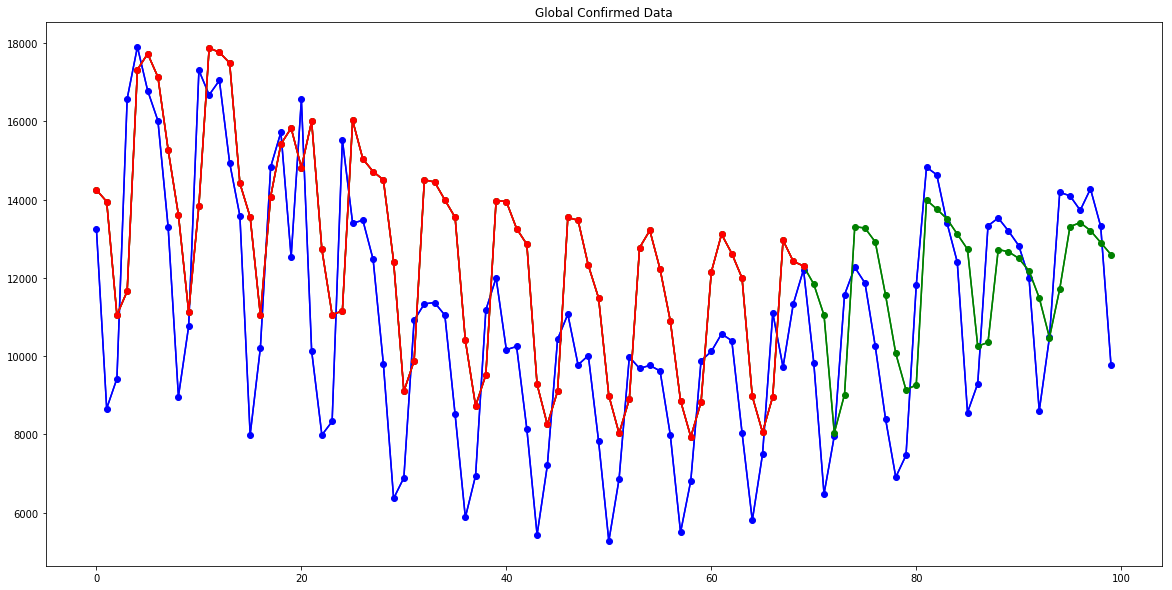

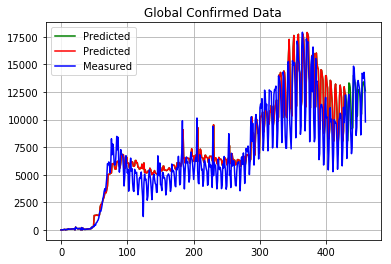

-----------------------------------------------------------------------------------------
| end of epoch  50 | time:  3.84s | mse loss 0.24098 | rmsle loss 0.00000 
-----------------------------------------------------------------------------------------
| epoch  51 |     3/   17 batches | lr 0.000365 | 32.26 ms | loss 0.24025 | ppl     1.27
| epoch  51 |     6/   17 batches | lr 0.000365 | 24.28 ms | loss 0.12271 | ppl     1.13


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  51 |     9/   17 batches | lr 0.000365 | 24.48 ms | loss 0.34736 | ppl     1.42
| epoch  51 |    12/   17 batches | lr 0.000365 | 24.57 ms | loss 0.33423 | ppl     1.40
| epoch  51 |    15/   17 batches | lr 0.000365 | 23.98 ms | loss 0.32069 | ppl     1.38
| epoch  52 |     3/   17 batches | lr 0.000347 | 31.65 ms | loss 0.20771 | ppl     1.23
| epoch  52 |     6/   17 batches | lr 0.000347 | 23.60 ms | loss 0.11698 | ppl     1.12
| epoch  52 |     9/   17 batches | lr 0.000347 | 25.48 ms | loss 0.34505 | ppl     1.41
| epoch  52 |    12/   17 batches | lr 0.000347 | 23.88 ms | loss 0.32938 | ppl     1.39
| epoch  52 |    15/   17 batches | lr 0.000347 | 24.63 ms | loss 0.31845 | ppl     1.37
| epoch  53 |     3/   17 batches | lr 0.000330 | 32.20 ms | loss 0.22573 | ppl     1.25
| epoch  53 |     6/   17 batches | lr 0.000330 | 23.92 ms | loss 0.11715 | ppl     1.12
| epoch  53 |     9/   17 batches | lr 0.000330 | 23.99 ms | loss 0.32469 | ppl     1.38
| epoch  53 |    12/ 

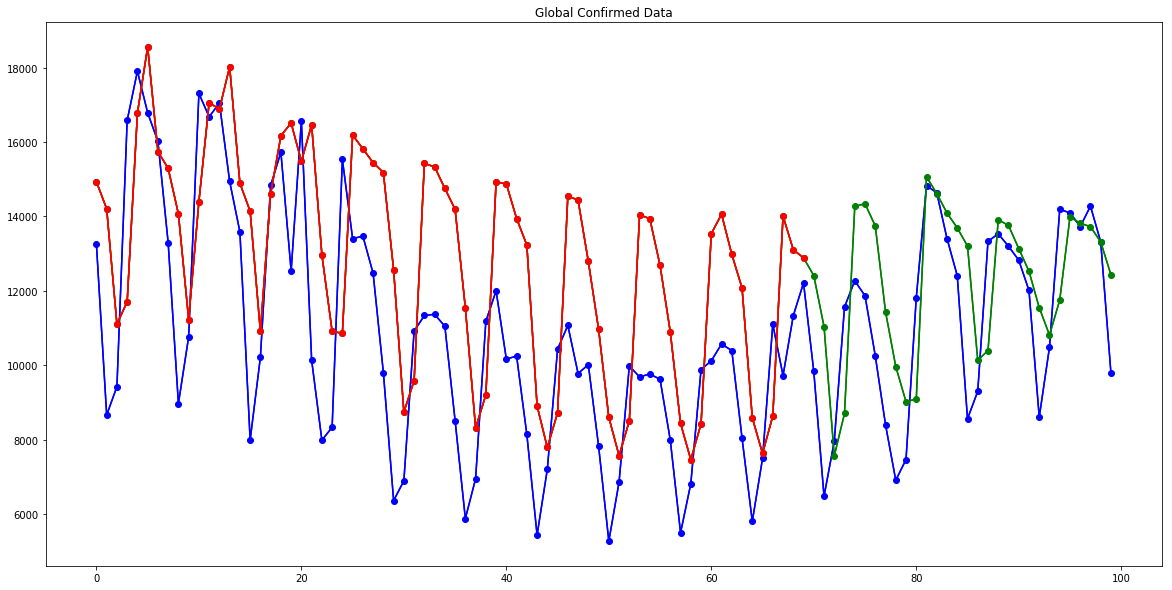

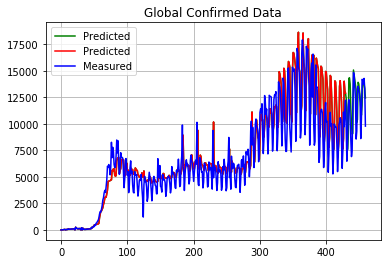

-----------------------------------------------------------------------------------------
| end of epoch  60 | time:  3.70s | mse loss 0.27352 | rmsle loss 0.00000 
-----------------------------------------------------------------------------------------
| epoch  61 |     3/   17 batches | lr 0.000219 | 33.33 ms | loss 0.21366 | ppl     1.24
| epoch  61 |     6/   17 batches | lr 0.000219 | 24.37 ms | loss 0.11532 | ppl     1.12


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  61 |     9/   17 batches | lr 0.000219 | 24.29 ms | loss 0.31189 | ppl     1.37
| epoch  61 |    12/   17 batches | lr 0.000219 | 25.27 ms | loss 0.30629 | ppl     1.36
| epoch  61 |    15/   17 batches | lr 0.000219 | 23.70 ms | loss 0.29917 | ppl     1.35
| epoch  62 |     3/   17 batches | lr 0.000208 | 43.45 ms | loss 0.20740 | ppl     1.23
| epoch  62 |     6/   17 batches | lr 0.000208 | 35.31 ms | loss 0.11368 | ppl     1.12
| epoch  62 |     9/   17 batches | lr 0.000208 | 37.64 ms | loss 0.31270 | ppl     1.37
| epoch  62 |    12/   17 batches | lr 0.000208 | 23.62 ms | loss 0.30248 | ppl     1.35
| epoch  62 |    15/   17 batches | lr 0.000208 | 24.76 ms | loss 0.29970 | ppl     1.35
| epoch  63 |     3/   17 batches | lr 0.000197 | 41.57 ms | loss 0.20396 | ppl     1.23
| epoch  63 |     6/   17 batches | lr 0.000197 | 30.78 ms | loss 0.11220 | ppl     1.12
| epoch  63 |     9/   17 batches | lr 0.000197 | 31.67 ms | loss 0.31433 | ppl     1.37
| epoch  63 |    12/ 

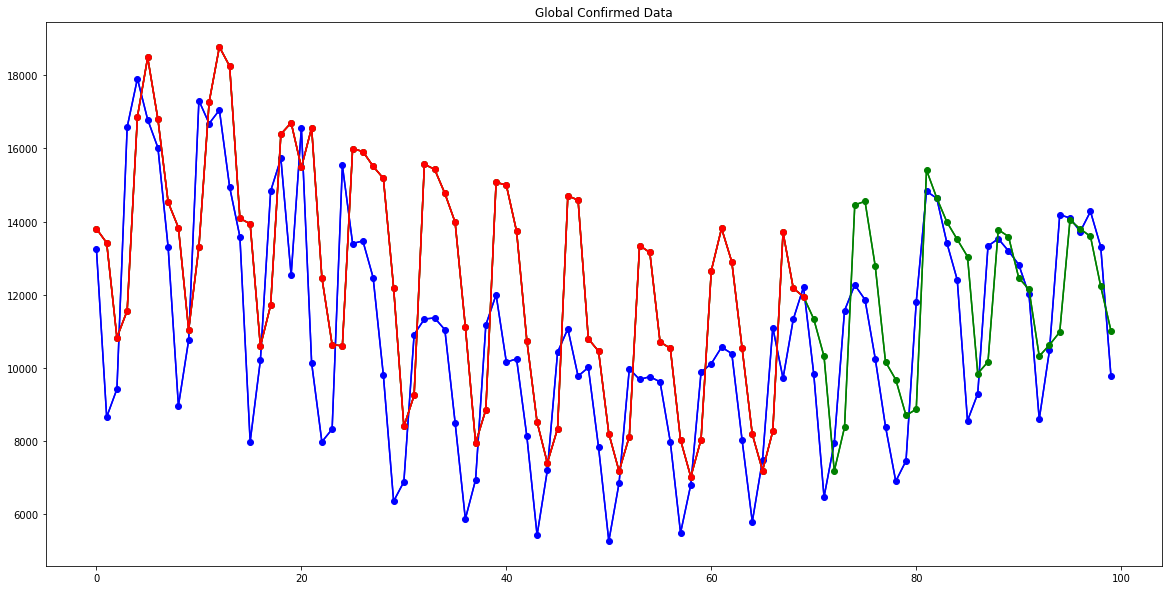

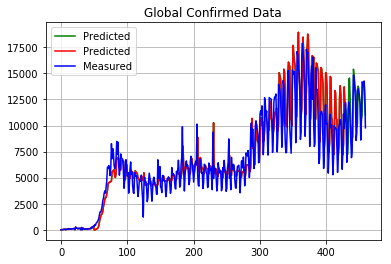

-----------------------------------------------------------------------------------------
| end of epoch  70 | time:  3.51s | mse loss 0.22313 | rmsle loss 0.00000 
-----------------------------------------------------------------------------------------
| epoch  71 |     3/   17 batches | lr 0.000131 | 37.00 ms | loss 0.19723 | ppl     1.22
| epoch  71 |     6/   17 batches | lr 0.000131 | 25.39 ms | loss 0.11109 | ppl     1.12


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  71 |     9/   17 batches | lr 0.000131 | 25.93 ms | loss 0.30376 | ppl     1.35
| epoch  71 |    12/   17 batches | lr 0.000131 | 25.44 ms | loss 0.29730 | ppl     1.35
| epoch  71 |    15/   17 batches | lr 0.000131 | 23.91 ms | loss 0.29200 | ppl     1.34
| epoch  72 |     3/   17 batches | lr 0.000124 | 32.56 ms | loss 0.20062 | ppl     1.22
| epoch  72 |     6/   17 batches | lr 0.000124 | 24.81 ms | loss 0.11213 | ppl     1.12
| epoch  72 |     9/   17 batches | lr 0.000124 | 30.21 ms | loss 0.30233 | ppl     1.35
| epoch  72 |    12/   17 batches | lr 0.000124 | 25.38 ms | loss 0.29490 | ppl     1.34
| epoch  72 |    15/   17 batches | lr 0.000124 | 32.59 ms | loss 0.29274 | ppl     1.34
| epoch  73 |     3/   17 batches | lr 0.000118 | 43.69 ms | loss 0.19856 | ppl     1.22
| epoch  73 |     6/   17 batches | lr 0.000118 | 29.65 ms | loss 0.11100 | ppl     1.12
| epoch  73 |     9/   17 batches | lr 0.000118 | 25.13 ms | loss 0.30117 | ppl     1.35
| epoch  73 |    12/ 

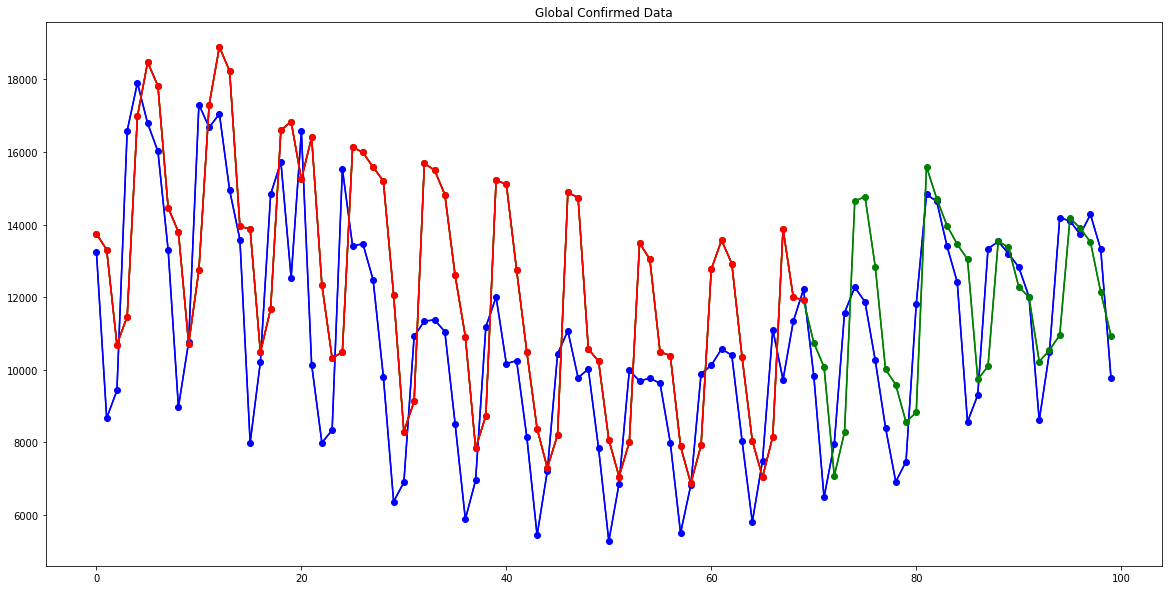

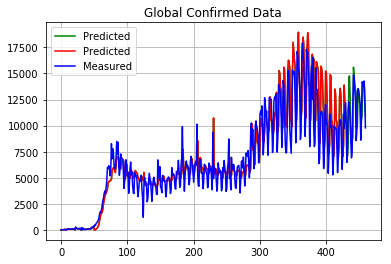

-----------------------------------------------------------------------------------------
| end of epoch  80 | time:  3.44s | mse loss 0.22163 | rmsle loss 0.00000 
-----------------------------------------------------------------------------------------
| epoch  81 |     3/   17 batches | lr 0.000078 | 33.28 ms | loss 0.19662 | ppl     1.22
| epoch  81 |     6/   17 batches | lr 0.000078 | 25.34 ms | loss 0.11106 | ppl     1.12


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  81 |     9/   17 batches | lr 0.000078 | 24.25 ms | loss 0.29810 | ppl     1.35
| epoch  81 |    12/   17 batches | lr 0.000078 | 24.42 ms | loss 0.28879 | ppl     1.33
| epoch  81 |    15/   17 batches | lr 0.000078 | 23.15 ms | loss 0.28649 | ppl     1.33
| epoch  82 |     3/   17 batches | lr 0.000075 | 33.19 ms | loss 0.19643 | ppl     1.22
| epoch  82 |     6/   17 batches | lr 0.000075 | 27.99 ms | loss 0.11059 | ppl     1.12
| epoch  82 |     9/   17 batches | lr 0.000075 | 23.20 ms | loss 0.29495 | ppl     1.34
| epoch  82 |    12/   17 batches | lr 0.000075 | 24.68 ms | loss 0.29110 | ppl     1.34
| epoch  82 |    15/   17 batches | lr 0.000075 | 35.26 ms | loss 0.28710 | ppl     1.33
| epoch  83 |     3/   17 batches | lr 0.000071 | 34.96 ms | loss 0.19760 | ppl     1.22
| epoch  83 |     6/   17 batches | lr 0.000071 | 23.74 ms | loss 0.11092 | ppl     1.12
| epoch  83 |     9/   17 batches | lr 0.000071 | 24.25 ms | loss 0.29748 | ppl     1.35
| epoch  83 |    12/ 

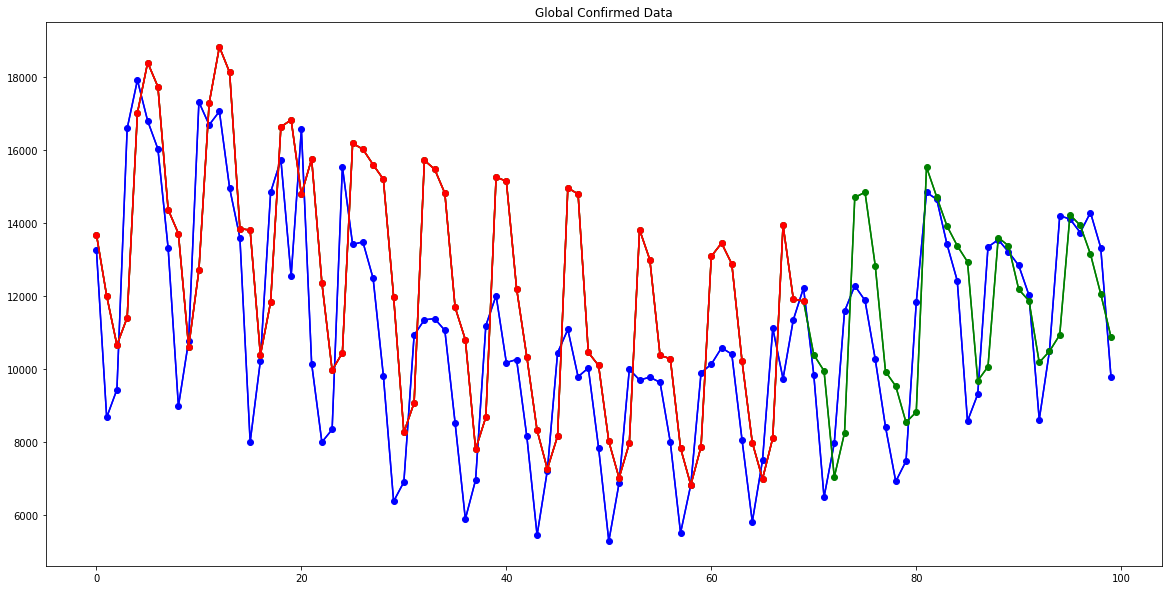

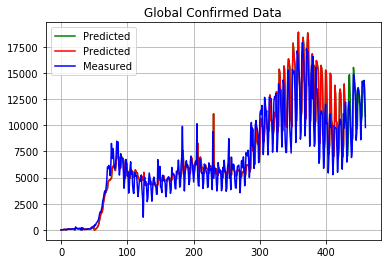

-----------------------------------------------------------------------------------------
| end of epoch  90 | time:  3.52s | mse loss 0.21890 | rmsle loss 0.00000 
-----------------------------------------------------------------------------------------
| epoch  91 |     3/   17 batches | lr 0.000047 | 33.62 ms | loss 0.19537 | ppl     1.22
| epoch  91 |     6/   17 batches | lr 0.000047 | 23.08 ms | loss 0.11049 | ppl     1.12


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch  91 |     9/   17 batches | lr 0.000047 | 24.32 ms | loss 0.29554 | ppl     1.34
| epoch  91 |    12/   17 batches | lr 0.000047 | 24.58 ms | loss 0.28604 | ppl     1.33
| epoch  91 |    15/   17 batches | lr 0.000047 | 23.87 ms | loss 0.28586 | ppl     1.33
| epoch  92 |     3/   17 batches | lr 0.000045 | 31.42 ms | loss 0.19496 | ppl     1.22
| epoch  92 |     6/   17 batches | lr 0.000045 | 27.33 ms | loss 0.10996 | ppl     1.12
| epoch  92 |     9/   17 batches | lr 0.000045 | 31.37 ms | loss 0.29302 | ppl     1.34
| epoch  92 |    12/   17 batches | lr 0.000045 | 26.09 ms | loss 0.28673 | ppl     1.33
| epoch  92 |    15/   17 batches | lr 0.000045 | 23.09 ms | loss 0.28491 | ppl     1.33
| epoch  93 |     3/   17 batches | lr 0.000042 | 31.88 ms | loss 0.19438 | ppl     1.21
| epoch  93 |     6/   17 batches | lr 0.000042 | 24.56 ms | loss 0.11112 | ppl     1.12
| epoch  93 |     9/   17 batches | lr 0.000042 | 23.35 ms | loss 0.29430 | ppl     1.34
| epoch  93 |    12/ 

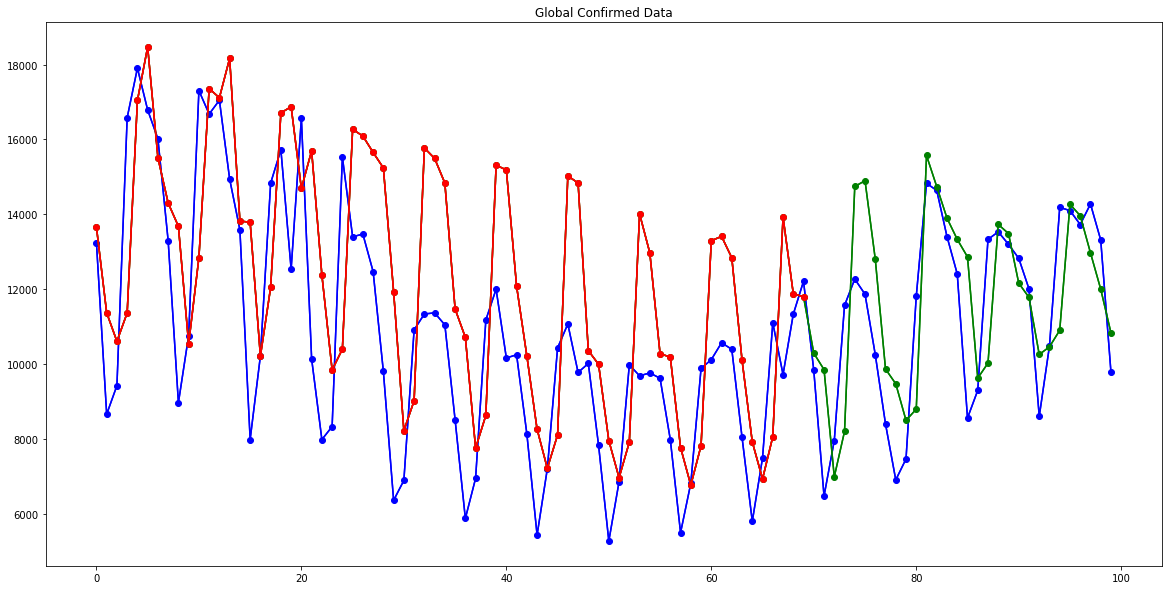

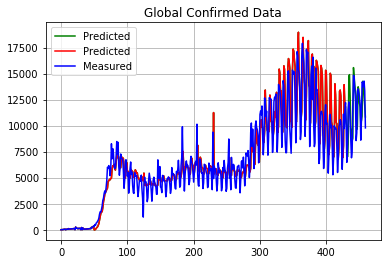

-----------------------------------------------------------------------------------------
| end of epoch 100 | time:  3.52s | mse loss 0.21993 | rmsle loss 0.00000 
-----------------------------------------------------------------------------------------
| epoch 101 |     3/   17 batches | lr 0.000028 | 34.15 ms | loss 0.19496 | ppl     1.22
| epoch 101 |     6/   17 batches | lr 0.000028 | 25.06 ms | loss 0.11004 | ppl     1.12


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 101 |     9/   17 batches | lr 0.000028 | 23.36 ms | loss 0.29226 | ppl     1.34
| epoch 101 |    12/   17 batches | lr 0.000028 | 23.59 ms | loss 0.28574 | ppl     1.33
| epoch 101 |    15/   17 batches | lr 0.000028 | 24.91 ms | loss 0.28313 | ppl     1.33
| epoch 102 |     3/   17 batches | lr 0.000027 | 32.97 ms | loss 0.19361 | ppl     1.21
| epoch 102 |     6/   17 batches | lr 0.000027 | 25.55 ms | loss 0.11015 | ppl     1.12
| epoch 102 |     9/   17 batches | lr 0.000027 | 26.26 ms | loss 0.29309 | ppl     1.34
| epoch 102 |    12/   17 batches | lr 0.000027 | 24.51 ms | loss 0.28470 | ppl     1.33
| epoch 102 |    15/   17 batches | lr 0.000027 | 23.28 ms | loss 0.28318 | ppl     1.33
| epoch 103 |     3/   17 batches | lr 0.000025 | 32.87 ms | loss 0.19490 | ppl     1.22
| epoch 103 |     6/   17 batches | lr 0.000025 | 30.31 ms | loss 0.10934 | ppl     1.12
| epoch 103 |     9/   17 batches | lr 0.000025 | 23.21 ms | loss 0.29229 | ppl     1.34
| epoch 103 |    12/ 

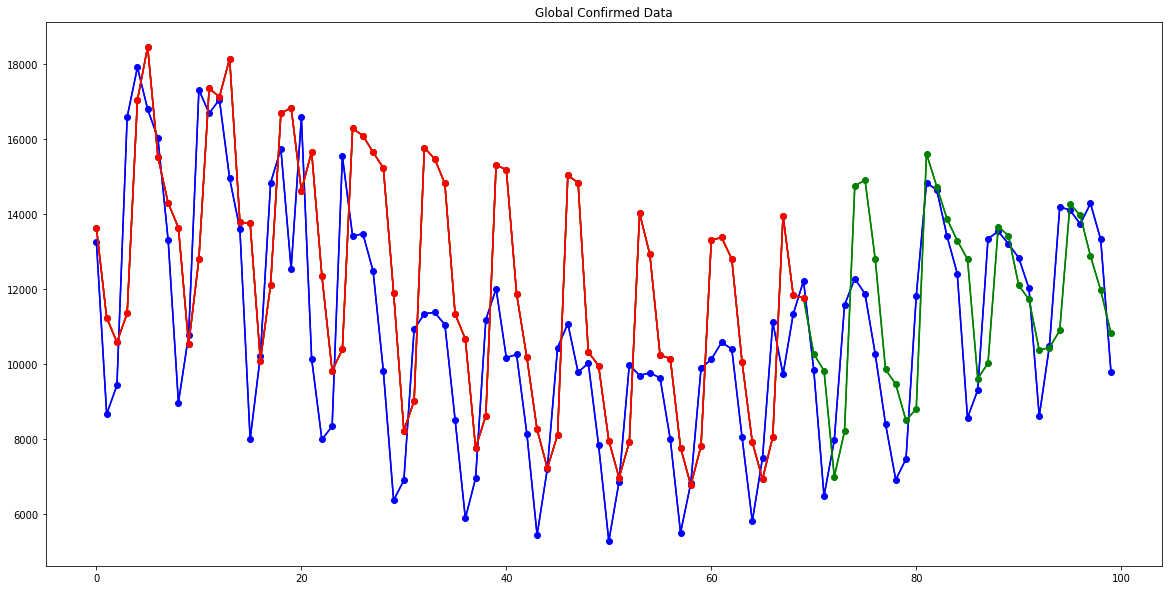

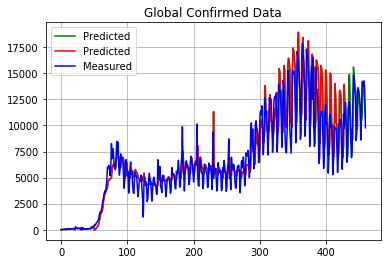

-----------------------------------------------------------------------------------------
| end of epoch 110 | time:  3.44s | mse loss 0.21946 | rmsle loss 0.00000 
-----------------------------------------------------------------------------------------
| epoch 111 |     3/   17 batches | lr 0.000017 | 31.26 ms | loss 0.19393 | ppl     1.21
| epoch 111 |     6/   17 batches | lr 0.000017 | 23.75 ms | loss 0.10896 | ppl     1.12


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 111 |     9/   17 batches | lr 0.000017 | 24.98 ms | loss 0.29342 | ppl     1.34
| epoch 111 |    12/   17 batches | lr 0.000017 | 23.88 ms | loss 0.28449 | ppl     1.33
| epoch 111 |    15/   17 batches | lr 0.000017 | 25.58 ms | loss 0.28305 | ppl     1.33
| epoch 112 |     3/   17 batches | lr 0.000016 | 33.78 ms | loss 0.19320 | ppl     1.21
| epoch 112 |     6/   17 batches | lr 0.000016 | 24.78 ms | loss 0.11000 | ppl     1.12
| epoch 112 |     9/   17 batches | lr 0.000016 | 35.65 ms | loss 0.29064 | ppl     1.34
| epoch 112 |    12/   17 batches | lr 0.000016 | 24.59 ms | loss 0.28352 | ppl     1.33
| epoch 112 |    15/   17 batches | lr 0.000016 | 29.53 ms | loss 0.28346 | ppl     1.33
| epoch 113 |     3/   17 batches | lr 0.000015 | 32.41 ms | loss 0.19296 | ppl     1.21
| epoch 113 |     6/   17 batches | lr 0.000015 | 23.07 ms | loss 0.10977 | ppl     1.12
| epoch 113 |     9/   17 batches | lr 0.000015 | 27.21 ms | loss 0.29131 | ppl     1.34
| epoch 113 |    12/ 

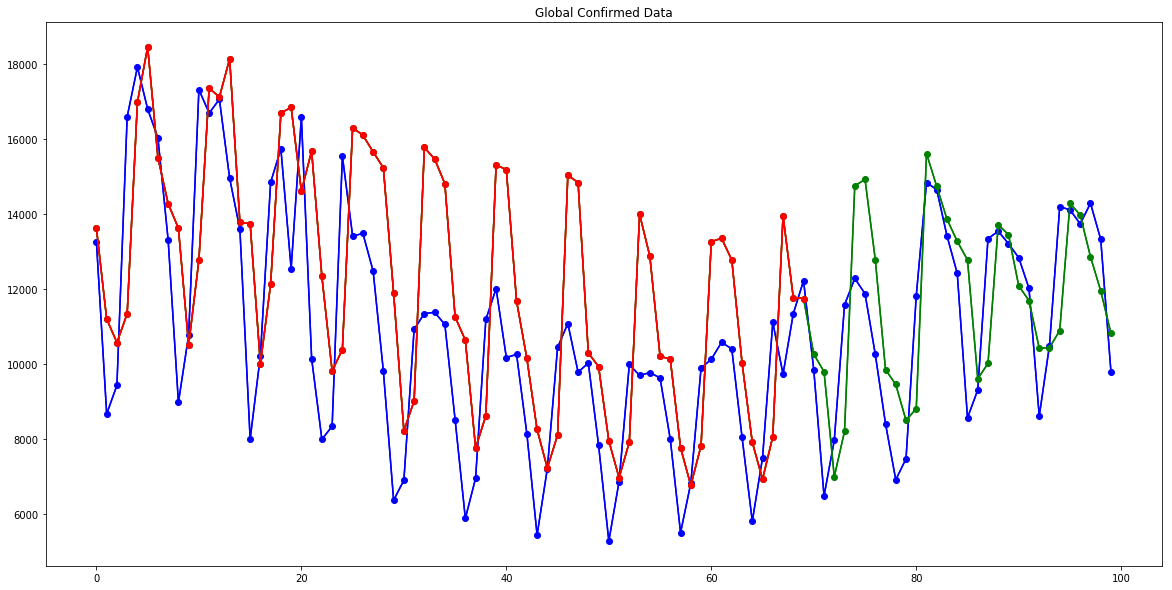

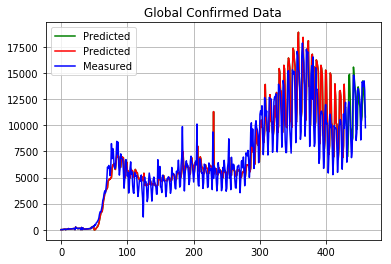

-----------------------------------------------------------------------------------------
| end of epoch 120 | time:  3.42s | mse loss 0.21920 | rmsle loss 0.00000 
-----------------------------------------------------------------------------------------
| epoch 121 |     3/   17 batches | lr 0.000010 | 41.68 ms | loss 0.19080 | ppl     1.21


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 121 |     6/   17 batches | lr 0.000010 | 29.03 ms | loss 0.10990 | ppl     1.12
| epoch 121 |     9/   17 batches | lr 0.000010 | 23.13 ms | loss 0.29205 | ppl     1.34
| epoch 121 |    12/   17 batches | lr 0.000010 | 24.89 ms | loss 0.28349 | ppl     1.33
| epoch 121 |    15/   17 batches | lr 0.000010 | 25.08 ms | loss 0.28138 | ppl     1.32
| epoch 122 |     3/   17 batches | lr 0.000010 | 34.90 ms | loss 0.19284 | ppl     1.21
| epoch 122 |     6/   17 batches | lr 0.000010 | 24.37 ms | loss 0.10936 | ppl     1.12
| epoch 122 |     9/   17 batches | lr 0.000010 | 31.61 ms | loss 0.29097 | ppl     1.34
| epoch 122 |    12/   17 batches | lr 0.000010 | 28.34 ms | loss 0.28534 | ppl     1.33
| epoch 122 |    15/   17 batches | lr 0.000010 | 23.43 ms | loss 0.28192 | ppl     1.33
| epoch 123 |     3/   17 batches | lr 0.000009 | 50.05 ms | loss 0.19338 | ppl     1.21
| epoch 123 |     6/   17 batches | lr 0.000009 | 34.26 ms | loss 0.10969 | ppl     1.12
| epoch 123 |     9/ 

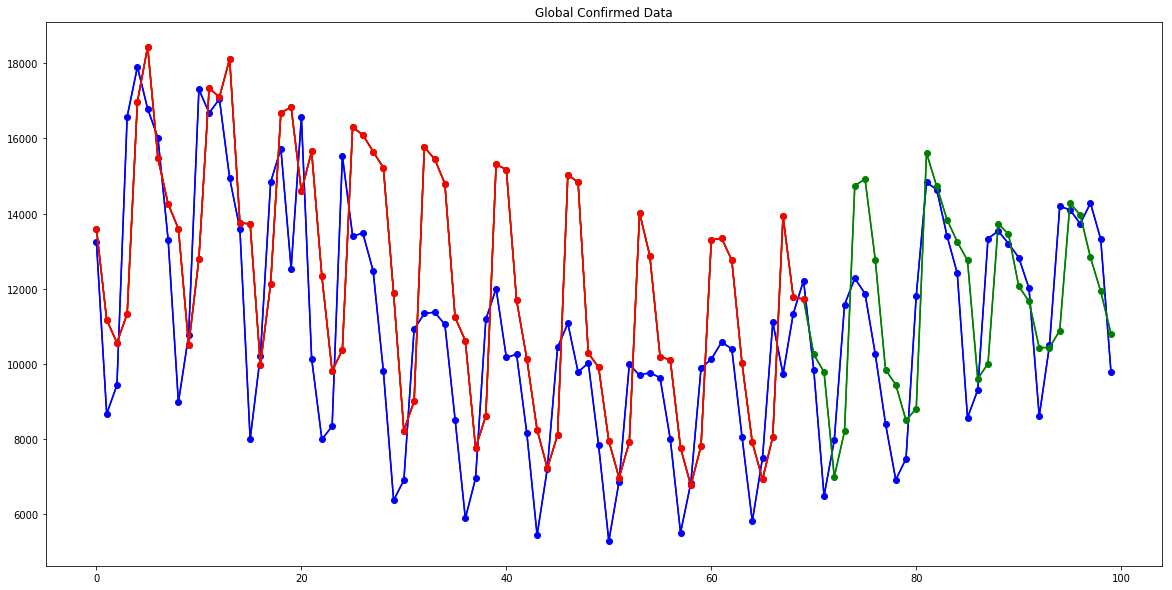

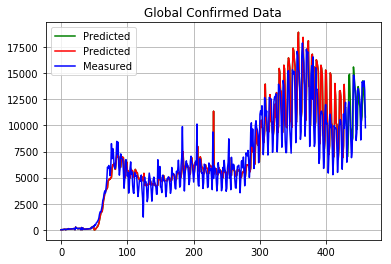

-----------------------------------------------------------------------------------------
| end of epoch 130 | time:  3.86s | mse loss 0.21916 | rmsle loss 0.00000 
-----------------------------------------------------------------------------------------
| epoch 131 |     3/   17 batches | lr 0.000006 | 36.65 ms | loss 0.19208 | ppl     1.21
| epoch 131 |     6/   17 batches | lr 0.000006 | 27.66 ms | loss 0.10943 | ppl     1.12


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 131 |     9/   17 batches | lr 0.000006 | 26.38 ms | loss 0.29081 | ppl     1.34
| epoch 131 |    12/   17 batches | lr 0.000006 | 25.49 ms | loss 0.28419 | ppl     1.33
| epoch 131 |    15/   17 batches | lr 0.000006 | 25.68 ms | loss 0.28312 | ppl     1.33
| epoch 132 |     3/   17 batches | lr 0.000006 | 40.24 ms | loss 0.19236 | ppl     1.21
| epoch 132 |     6/   17 batches | lr 0.000006 | 38.68 ms | loss 0.10894 | ppl     1.12
| epoch 132 |     9/   17 batches | lr 0.000006 | 32.56 ms | loss 0.29180 | ppl     1.34
| epoch 132 |    12/   17 batches | lr 0.000006 | 24.85 ms | loss 0.28209 | ppl     1.33
| epoch 132 |    15/   17 batches | lr 0.000006 | 23.82 ms | loss 0.28210 | ppl     1.33
| epoch 133 |     3/   17 batches | lr 0.000005 | 35.71 ms | loss 0.19212 | ppl     1.21
| epoch 133 |     6/   17 batches | lr 0.000005 | 23.97 ms | loss 0.10905 | ppl     1.12
| epoch 133 |     9/   17 batches | lr 0.000005 | 26.89 ms | loss 0.29057 | ppl     1.34
| epoch 133 |    12/ 

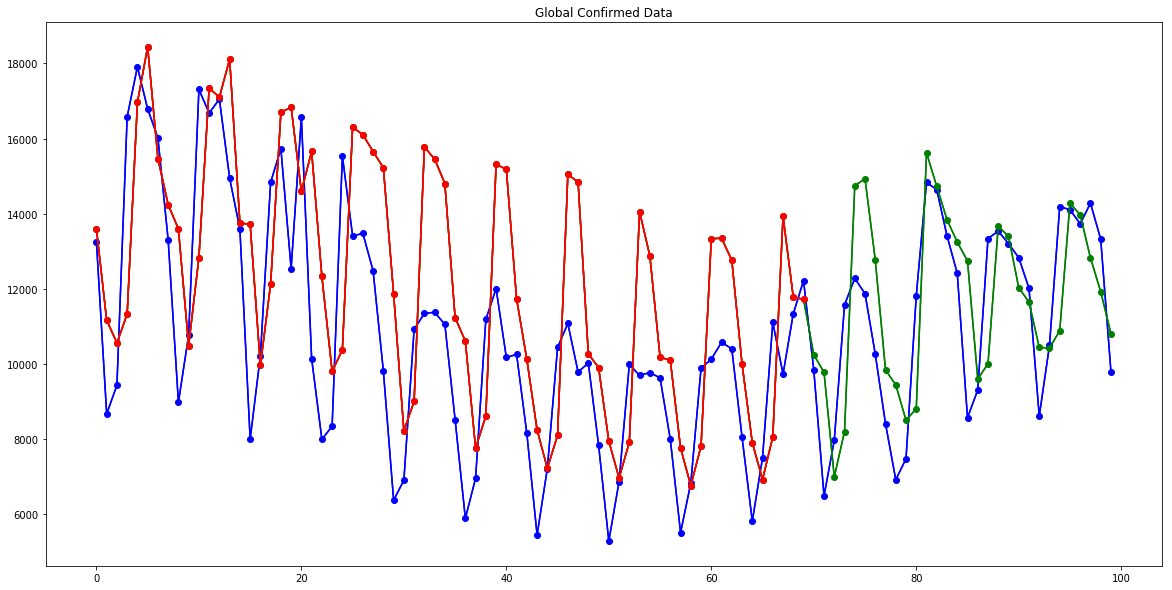

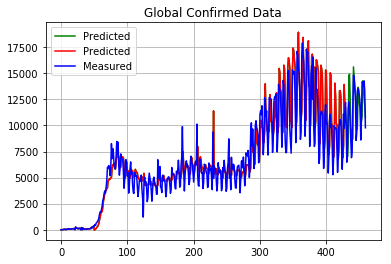

-----------------------------------------------------------------------------------------
| end of epoch 140 | time:  3.51s | mse loss 0.21924 | rmsle loss 0.00000 
-----------------------------------------------------------------------------------------
| epoch 141 |     3/   17 batches | lr 0.000004 | 33.57 ms | loss 0.19303 | ppl     1.21
| epoch 141 |     6/   17 batches | lr 0.000004 | 23.39 ms | loss 0.11011 | ppl     1.12


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 141 |     9/   17 batches | lr 0.000004 | 24.32 ms | loss 0.29232 | ppl     1.34
| epoch 141 |    12/   17 batches | lr 0.000004 | 24.72 ms | loss 0.28443 | ppl     1.33
| epoch 141 |    15/   17 batches | lr 0.000004 | 29.27 ms | loss 0.28275 | ppl     1.33
| epoch 142 |     3/   17 batches | lr 0.000003 | 42.30 ms | loss 0.19130 | ppl     1.21
| epoch 142 |     6/   17 batches | lr 0.000003 | 25.38 ms | loss 0.10930 | ppl     1.12
| epoch 142 |     9/   17 batches | lr 0.000003 | 27.57 ms | loss 0.29157 | ppl     1.34
| epoch 142 |    12/   17 batches | lr 0.000003 | 25.76 ms | loss 0.28428 | ppl     1.33
| epoch 142 |    15/   17 batches | lr 0.000003 | 26.83 ms | loss 0.28225 | ppl     1.33
| epoch 143 |     3/   17 batches | lr 0.000003 | 31.98 ms | loss 0.19363 | ppl     1.21
| epoch 143 |     6/   17 batches | lr 0.000003 | 23.93 ms | loss 0.11009 | ppl     1.12
| epoch 143 |     9/   17 batches | lr 0.000003 | 26.03 ms | loss 0.29111 | ppl     1.34
| epoch 143 |    12/ 

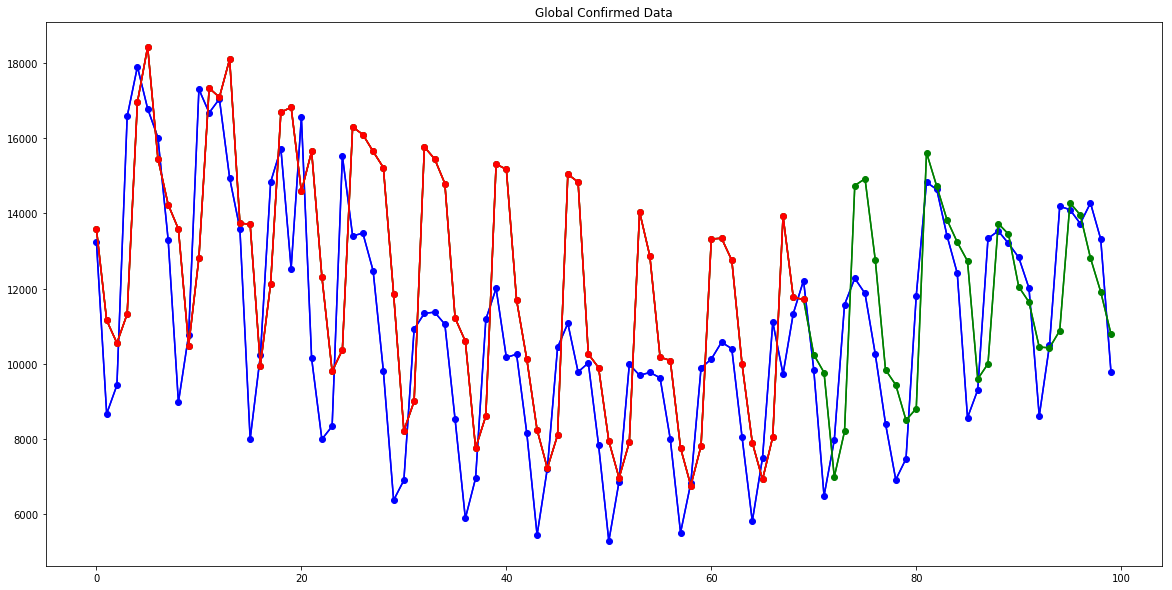

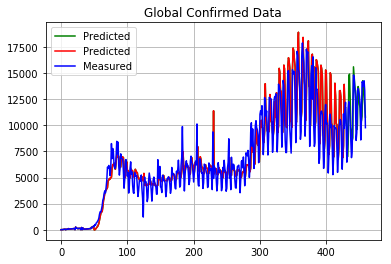

-----------------------------------------------------------------------------------------
| end of epoch 150 | time:  4.07s | mse loss 0.21904 | rmsle loss 0.00000 
-----------------------------------------------------------------------------------------
| epoch 151 |     3/   17 batches | lr 0.000002 | 32.52 ms | loss 0.19276 | ppl     1.21
| epoch 151 |     6/   17 batches | lr 0.000002 | 24.01 ms | loss 0.11033 | ppl     1.12


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 151 |     9/   17 batches | lr 0.000002 | 24.52 ms | loss 0.29158 | ppl     1.34
| epoch 151 |    12/   17 batches | lr 0.000002 | 23.40 ms | loss 0.28119 | ppl     1.32
| epoch 151 |    15/   17 batches | lr 0.000002 | 23.15 ms | loss 0.28208 | ppl     1.33
| epoch 152 |     3/   17 batches | lr 0.000002 | 36.60 ms | loss 0.19161 | ppl     1.21
| epoch 152 |     6/   17 batches | lr 0.000002 | 29.21 ms | loss 0.10901 | ppl     1.12
| epoch 152 |     9/   17 batches | lr 0.000002 | 34.28 ms | loss 0.28932 | ppl     1.34
| epoch 152 |    12/   17 batches | lr 0.000002 | 29.08 ms | loss 0.28345 | ppl     1.33
| epoch 152 |    15/   17 batches | lr 0.000002 | 24.73 ms | loss 0.28233 | ppl     1.33
| epoch 153 |     3/   17 batches | lr 0.000002 | 34.19 ms | loss 0.19185 | ppl     1.21
| epoch 153 |     6/   17 batches | lr 0.000002 | 23.31 ms | loss 0.10942 | ppl     1.12
| epoch 153 |     9/   17 batches | lr 0.000002 | 23.29 ms | loss 0.29025 | ppl     1.34
| epoch 153 |    12/ 

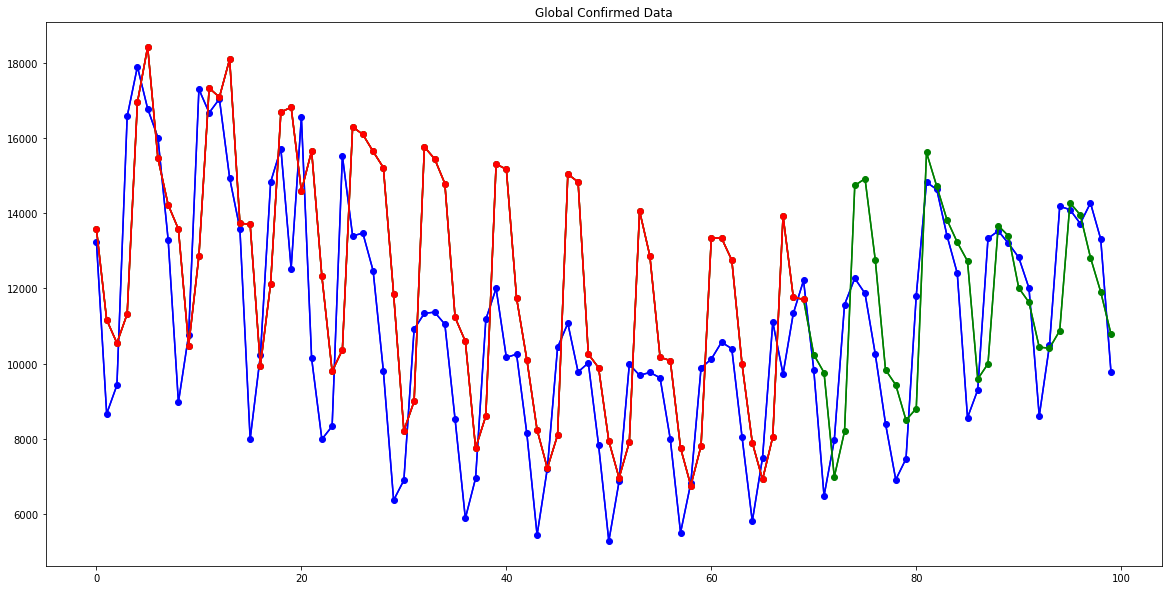

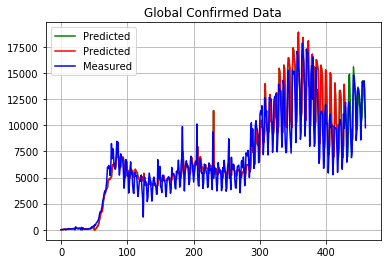

-----------------------------------------------------------------------------------------
| end of epoch 160 | time:  3.44s | mse loss 0.21894 | rmsle loss 0.00000 
-----------------------------------------------------------------------------------------
| epoch 161 |     3/   17 batches | lr 0.000001 | 32.83 ms | loss 0.19394 | ppl     1.21
| epoch 161 |     6/   17 batches | lr 0.000001 | 26.66 ms | loss 0.10941 | ppl     1.12


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 161 |     9/   17 batches | lr 0.000001 | 27.37 ms | loss 0.28967 | ppl     1.34
| epoch 161 |    12/   17 batches | lr 0.000001 | 50.87 ms | loss 0.28333 | ppl     1.33
| epoch 161 |    15/   17 batches | lr 0.000001 | 30.88 ms | loss 0.28056 | ppl     1.32
| epoch 162 |     3/   17 batches | lr 0.000001 | 33.35 ms | loss 0.19284 | ppl     1.21
| epoch 162 |     6/   17 batches | lr 0.000001 | 26.34 ms | loss 0.10962 | ppl     1.12
| epoch 162 |     9/   17 batches | lr 0.000001 | 28.16 ms | loss 0.29121 | ppl     1.34
| epoch 162 |    12/   17 batches | lr 0.000001 | 30.90 ms | loss 0.28292 | ppl     1.33
| epoch 162 |    15/   17 batches | lr 0.000001 | 24.04 ms | loss 0.28345 | ppl     1.33
| epoch 163 |     3/   17 batches | lr 0.000001 | 31.75 ms | loss 0.19220 | ppl     1.21
| epoch 163 |     6/   17 batches | lr 0.000001 | 23.85 ms | loss 0.10918 | ppl     1.12
| epoch 163 |     9/   17 batches | lr 0.000001 | 23.54 ms | loss 0.28990 | ppl     1.34
| epoch 163 |    12/ 

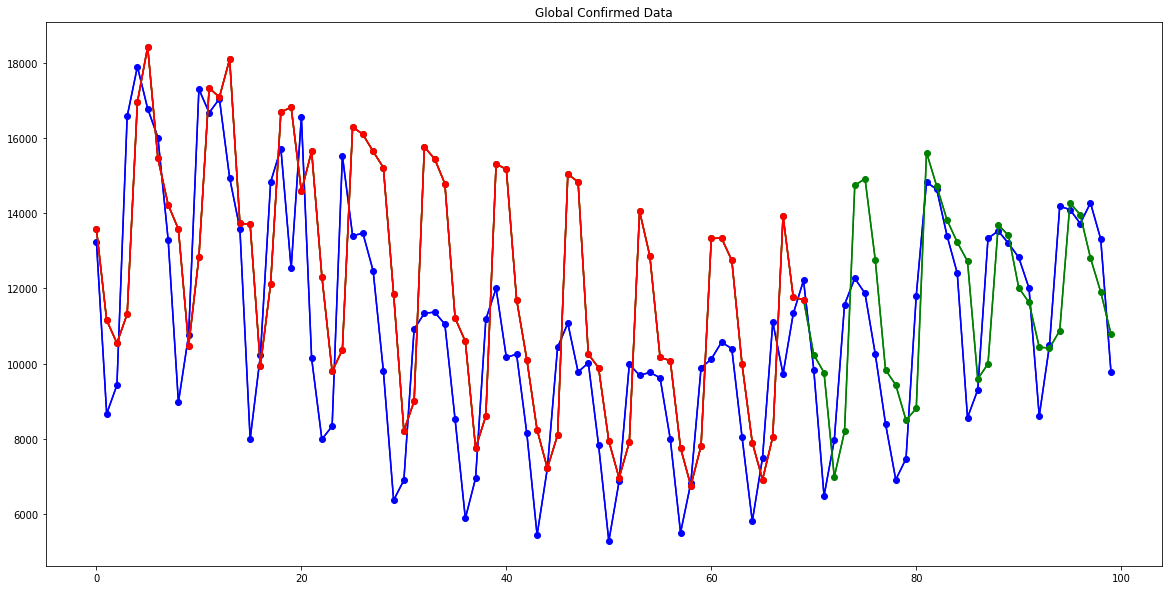

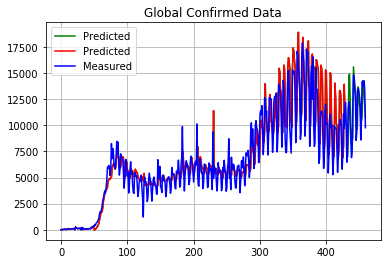

-----------------------------------------------------------------------------------------
| end of epoch 170 | time:  3.80s | mse loss 0.21891 | rmsle loss 0.00000 
-----------------------------------------------------------------------------------------
| epoch 171 |     3/   17 batches | lr 0.000001 | 33.43 ms | loss 0.19312 | ppl     1.21
| epoch 171 |     6/   17 batches | lr 0.000001 | 27.19 ms | loss 0.10891 | ppl     1.12


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 171 |     9/   17 batches | lr 0.000001 | 32.81 ms | loss 0.29094 | ppl     1.34
| epoch 171 |    12/   17 batches | lr 0.000001 | 33.40 ms | loss 0.28276 | ppl     1.33
| epoch 171 |    15/   17 batches | lr 0.000001 | 29.62 ms | loss 0.28167 | ppl     1.33
| epoch 172 |     3/   17 batches | lr 0.000001 | 39.67 ms | loss 0.19158 | ppl     1.21
| epoch 172 |     6/   17 batches | lr 0.000001 | 24.77 ms | loss 0.10915 | ppl     1.12
| epoch 172 |     9/   17 batches | lr 0.000001 | 23.85 ms | loss 0.28974 | ppl     1.34
| epoch 172 |    12/   17 batches | lr 0.000001 | 24.61 ms | loss 0.28459 | ppl     1.33
| epoch 172 |    15/   17 batches | lr 0.000001 | 24.30 ms | loss 0.28102 | ppl     1.32
| epoch 173 |     3/   17 batches | lr 0.000001 | 31.76 ms | loss 0.19165 | ppl     1.21
| epoch 173 |     6/   17 batches | lr 0.000001 | 25.09 ms | loss 0.10946 | ppl     1.12
| epoch 173 |     9/   17 batches | lr 0.000001 | 24.27 ms | loss 0.29083 | ppl     1.34
| epoch 173 |    12/ 

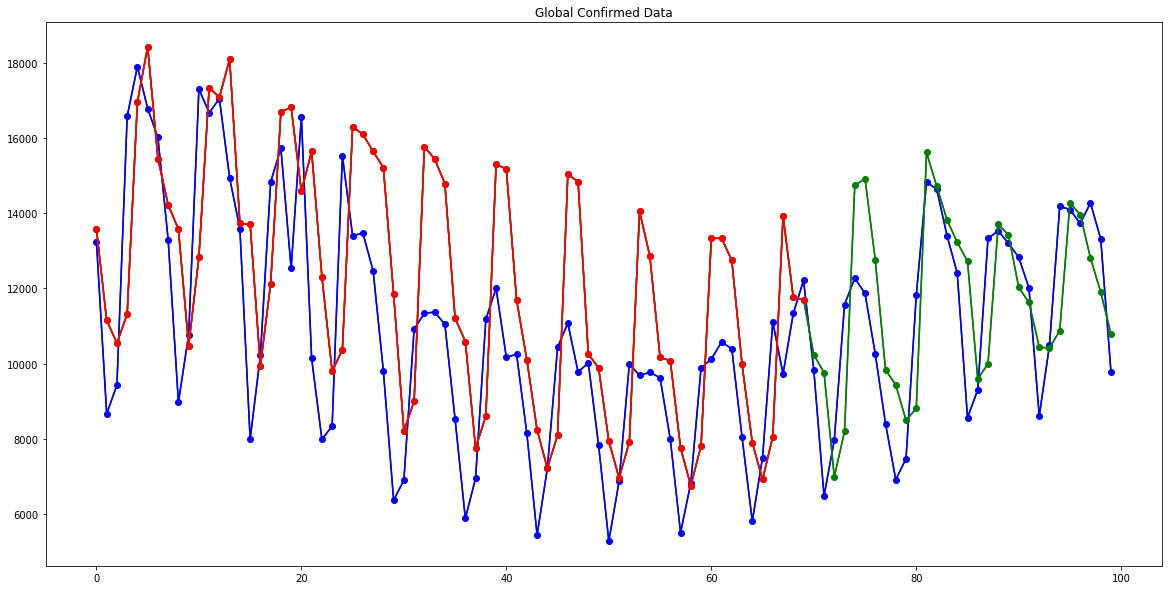

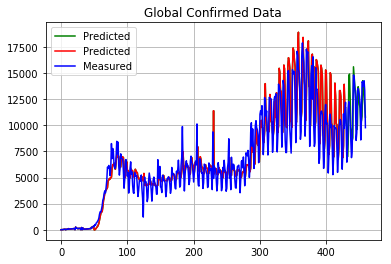

-----------------------------------------------------------------------------------------
| end of epoch 180 | time:  3.36s | mse loss 0.21888 | rmsle loss 0.00000 
-----------------------------------------------------------------------------------------
| epoch 181 |     3/   17 batches | lr 0.000000 | 32.76 ms | loss 0.19129 | ppl     1.21
| epoch 181 |     6/   17 batches | lr 0.000000 | 23.48 ms | loss 0.10895 | ppl     1.12


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 181 |     9/   17 batches | lr 0.000000 | 24.40 ms | loss 0.29139 | ppl     1.34
| epoch 181 |    12/   17 batches | lr 0.000000 | 24.07 ms | loss 0.28381 | ppl     1.33
| epoch 181 |    15/   17 batches | lr 0.000000 | 23.52 ms | loss 0.28329 | ppl     1.33
| epoch 182 |     3/   17 batches | lr 0.000000 | 30.98 ms | loss 0.19237 | ppl     1.21
| epoch 182 |     6/   17 batches | lr 0.000000 | 23.02 ms | loss 0.11023 | ppl     1.12
| epoch 182 |     9/   17 batches | lr 0.000000 | 24.33 ms | loss 0.28983 | ppl     1.34
| epoch 182 |    12/   17 batches | lr 0.000000 | 23.11 ms | loss 0.28259 | ppl     1.33
| epoch 182 |    15/   17 batches | lr 0.000000 | 23.40 ms | loss 0.28160 | ppl     1.33
| epoch 183 |     3/   17 batches | lr 0.000000 | 31.60 ms | loss 0.19144 | ppl     1.21
| epoch 183 |     6/   17 batches | lr 0.000000 | 23.35 ms | loss 0.10846 | ppl     1.11
| epoch 183 |     9/   17 batches | lr 0.000000 | 23.25 ms | loss 0.29061 | ppl     1.34
| epoch 183 |    12/ 

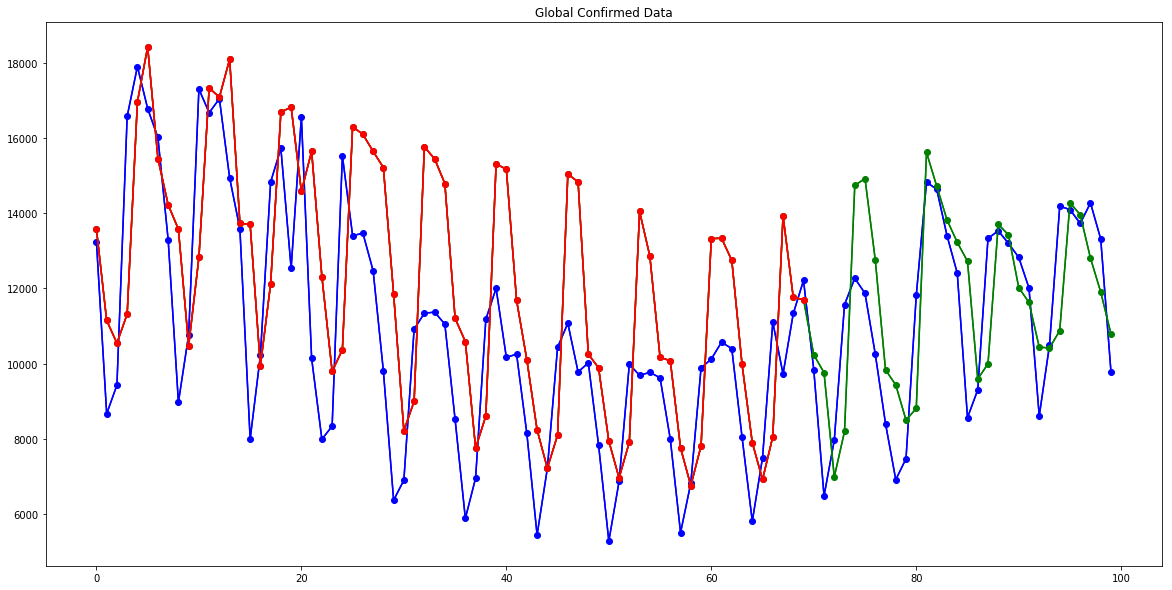

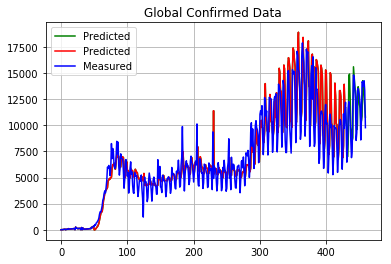

-----------------------------------------------------------------------------------------
| end of epoch 190 | time:  3.49s | mse loss 0.21889 | rmsle loss 0.00000 
-----------------------------------------------------------------------------------------
| epoch 191 |     3/   17 batches | lr 0.000000 | 34.06 ms | loss 0.19210 | ppl     1.21
| epoch 191 |     6/   17 batches | lr 0.000000 | 24.76 ms | loss 0.10916 | ppl     1.12


/opt/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch 191 |     9/   17 batches | lr 0.000000 | 24.63 ms | loss 0.29130 | ppl     1.34
| epoch 191 |    12/   17 batches | lr 0.000000 | 24.51 ms | loss 0.28338 | ppl     1.33
| epoch 191 |    15/   17 batches | lr 0.000000 | 23.62 ms | loss 0.28250 | ppl     1.33
| epoch 192 |     3/   17 batches | lr 0.000000 | 31.72 ms | loss 0.19087 | ppl     1.21
| epoch 192 |     6/   17 batches | lr 0.000000 | 23.80 ms | loss 0.10941 | ppl     1.12
| epoch 192 |     9/   17 batches | lr 0.000000 | 23.94 ms | loss 0.29122 | ppl     1.34
| epoch 192 |    12/   17 batches | lr 0.000000 | 23.26 ms | loss 0.28442 | ppl     1.33
| epoch 192 |    15/   17 batches | lr 0.000000 | 26.26 ms | loss 0.28255 | ppl     1.33
| epoch 193 |     3/   17 batches | lr 0.000000 | 34.78 ms | loss 0.19496 | ppl     1.22
| epoch 193 |     6/   17 batches | lr 0.000000 | 23.69 ms | loss 0.10938 | ppl     1.12
| epoch 193 |     9/   17 batches | lr 0.000000 | 23.26 ms | loss 0.29126 | ppl     1.34
| epoch 193 |    12/ 

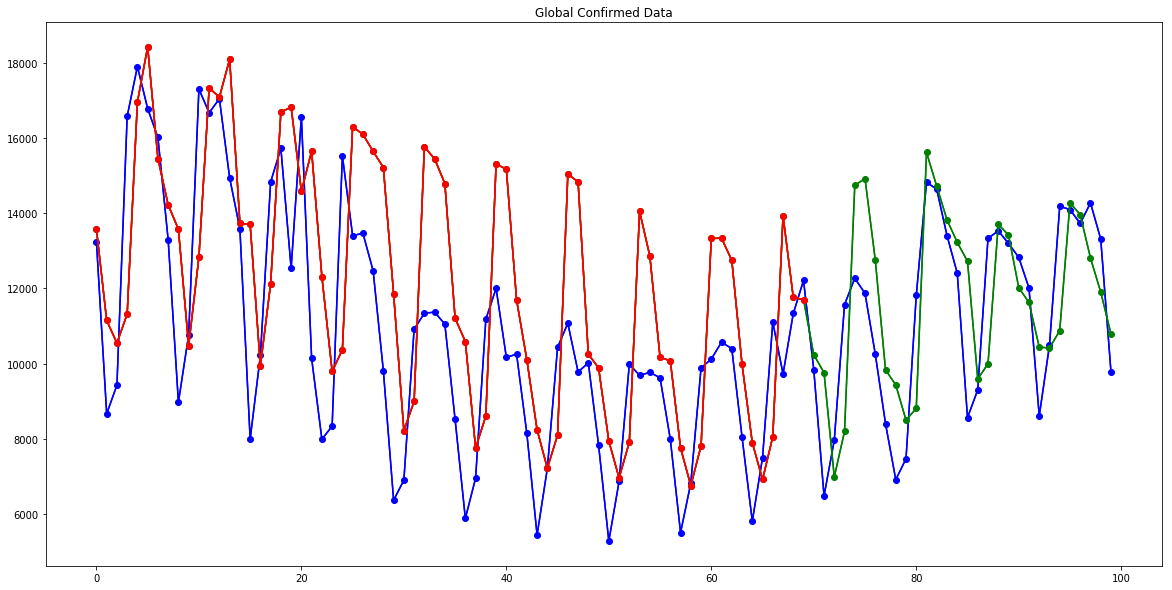

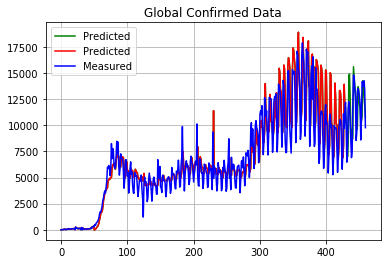

-----------------------------------------------------------------------------------------
| end of epoch 200 | time:  3.45s | mse loss 0.21888 | rmsle loss 0.00000 
-----------------------------------------------------------------------------------------


In [70]:
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv",
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_global_del30_fatality_noise_1000_everyday.npy")
train_data, val_data = dealData.trainTestData()
# train_data = dealData.train_data()
model = TransAm().to(device)

criterion = nn.MSELoss()
lr = 0.005 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

best_val_loss = float("inf")
epochs = 200 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)

    if(epoch % 10 is 0):
#         mse, rmsle, truth, test_result = dealData.get_plot_data(model)
#         plot_image(truth, test_result)
        mse, rmsle = dealData.plot_and_loss(model, epoch, True)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | mse loss {:5.5f} | rmsle loss {:5.5f} '.format(epoch, (time.time() - epoch_start_time),
                                         mse, rmsle))
        print('-' * 89)

    scheduler.step() 
#     saveModel(model, "parameter_global_confirmed_50sq_del30_changeLoss_noise_" + str(i) + "_best") 

In [73]:
# saveModel(model, "parameter_global_fatality_50sq_del30_noise_best_everyday") 

# Load Model

460 460
mse:  0.21887933
rmsle:  0.0
mae:  0.3604854
mape:  1.3534524
rmse:  0.4678454


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



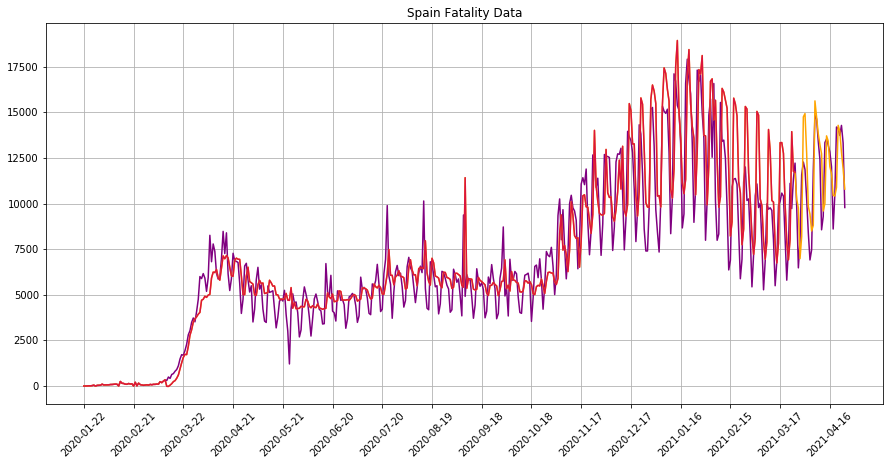

In [74]:
pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_global_fatality_50sq_del30_noise_best_everyday")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv",
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_global_del30_fatality_noise_1000_everyday.npy")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Spain Fatality Data', isSave = True)

460 460
mse:  0.24996321
rmsle:  0.0
mae:  0.3876506
mape:  1.4934703
rmse:  0.4999632


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



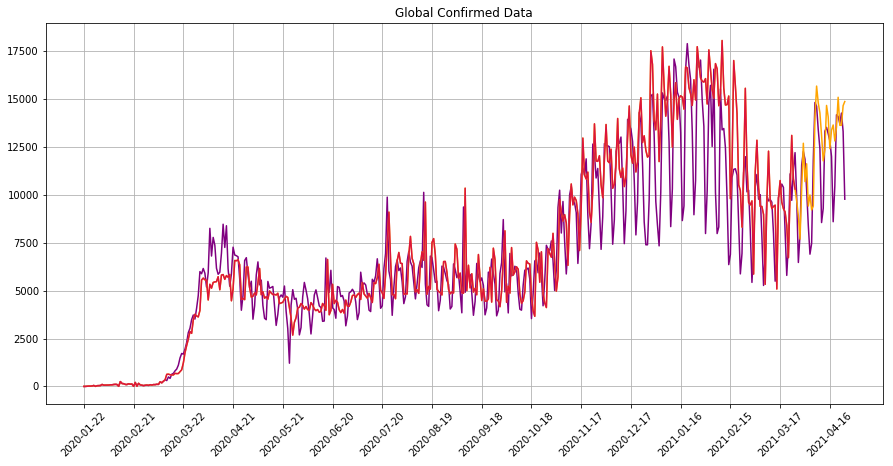

In [75]:
pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_global_fatality_50sq_del30_SJ_best_everyday")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv",
                        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_global_del30_fatality_SJ_noise_1000_everyday.npy")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Global Confirmed Data', isSave = True)

460 460
mse:  0.25704363
rmsle:  0.0
mae:  0.39570612
mape:  0.9331744
rmse:  0.5069947


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



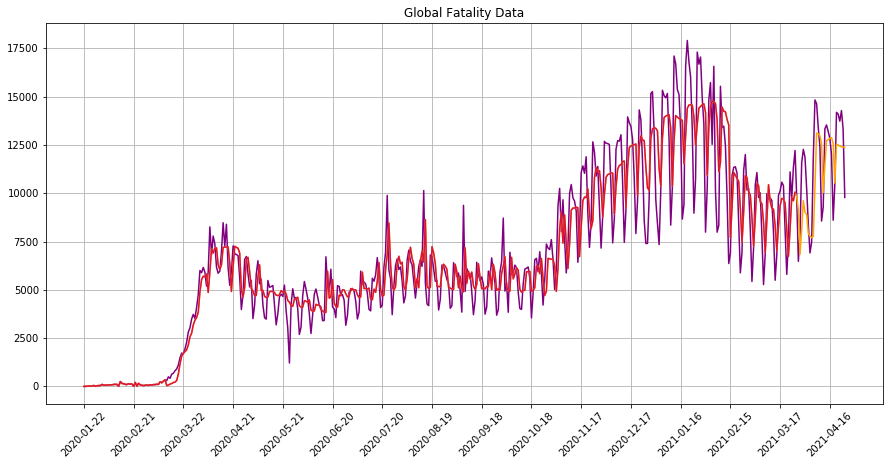

In [76]:
pmodel = TransAm().to(device)
pmodel = loadModel(pmodel, "parameter_global_fatality_50sq_del30_NoGan_best_everyday")
dealData = DealData("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv")
df = pd.read_csv("/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv")
mse, rmsle, mae, mape, rmse, truth, test_result = dealData.get_plot_data(pmodel)
print("mse: ", mse)
print("rmsle: ", rmsle)
print("mae: ", mae)
print("mape: ", mape)
print("rmse: ", rmse)
plot_image(truth, test_result, start = df.date[0], end = df.date[df.shape[0]-1], title = 'Global Fatality Data', isSave = True)